# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 1.3855199722456745e-05, 2: 1.1251000250922516e-05, 3: 1.1632099631242455e-05, 4: 1.5687899940530768e-05, 5: 1.6089999917312525e-05, 6: 1.8450899733579718e-05, 7: 2.7825899451272562e-05, 8: 2.2726599490852094e-05, 9: 2.5226699290215037e-05, 10: 2.9452500166371463e-05, 11: 3.019340001628734e-05, 12: 3.3420700128772295e-05, 13: 4.097519922652282e-05, 14: 3.886439990310464e-05, 15: 4.136809875490144e-05, 16: 4.490370047278702e-05, 17: 5.010939967178274e-05, 18: 5.1647800137288866e-05, 19: 5.457389961520676e-05, 20: 5.836119926243555e-05, 21: 6.325869981083088e-05, 22: 6.619170053454582e-05, 23: 0.00014093180034251417, 24: 7.692249964748043e-05, 25: 7.681040005991235e-05, 26: 8.090380069916136e-05, 27: 8.823779971862677e-05}


### Random 1-qubit unitary initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

{1: 8.332599463756196e-06, 2: 5.7093700525001624e-05, 3: 0.000219011399167357, 4: 0.00017752559979271608, 5: 0.00024488010021741504, 6: 0.0003038066002773121, 7: 0.0003848090007522842, 8: 0.0005198550999921281, 9: 0.0005879068994545378, 10: 0.0009210557000187691, 11: 0.00157876569974178, 12: 0.002029147900248063, 13: 0.002459176599586499, 14: 0.0028859864003607074, 15: 0.0033714318997226655, 16: 0.003985787500278093, 17: 0.004554944700066699, 18: 0.005186646099173231, 19: 0.006245433900403441, 20: 0.007937109499471262, 21: 0.011397115499494247, 22: 0.017962512899612194, 23: 0.02965724420027982, 24: 0.05603050039972004, 25: 0.0983968525997625, 26: 0.17629290769982617, 27: 0.36992947470062065}


### GHZ state initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 3.0128000435070135e-05, 2: 4.4350300231599246e-05, 3: 0.00014224549995560664, 4: 0.00016737580044718926, 5: 0.00016502760008734184, 6: 0.0002188434998970479, 7: 0.0002454491001117276, 8: 0.0002680633006093558, 9: 0.00042198599985567855, 10: 0.0007397468998533441, 11: 0.001982985300128348, 12: 0.002238672598832636, 13: 0.0025825886994425675, 14: 0.0027843311007018203, 15: 0.003236718700645724, 16: 0.003166418800901738, 17: 0.0033736181001586376, 18: 0.0036720967007568108, 19: 0.0046113262000289975, 20: 0.008313172699490678, 21: 0.015242510800089804, 22: 0.027598056700298912, 23: 0.054092894999485, 24: 0.11740640300049562, 25: 0.2350209445005021, 26: 0.4506751900007657, 27: 0.9740879528009827}


## FFTW ("Classical" DFT)

In [7]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

### |0> initialization

In [8]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 6.279020053625572e-05, 2: 0.00011077490016759839, 3: 3.675890038721263e-05, 4: 3.960479989473242e-05, 5: 4.466699974727817e-05, 6: 3.473589895293116e-05, 7: 3.4954699003719725e-05, 8: 3.483419932308607e-05, 9: 3.646399927674793e-05, 10: 3.837809999822639e-05, 11: 4.426300074555911e-05, 12: 6.0115299856988716e-05, 13: 0.00010387330075900536, 14: 0.0001775822998752119, 15: 0.0003623082004196476, 16: 0.0007151651996537111, 17: 0.001518692400350119, 18: 0.0036005984991788866, 19: 0.010837694899237249, 20: 0.018727371400382255, 21: 0.04697672970032727, 22: 0.07223421340058848, 23: 0.1307898198003386, 24: 0.2377715036003792, 25: 0.4432933259002311, 26: 1.0386882382994371, 27: 2.0483136703995113}


### Random 1-qubit unitary initialization

In [9]:
fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        
        # Use Qrack to initialize the test case!
        sim = QrackSimulator(n)
        for i in range(n):
            # Initialize with uniformly random single qubit gates, across full width.
            sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
        ket = sim.out_ket()
        del sim
        for i in range(2**n):
            io_array[i] = ket[i]
        del ket
        
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 3.184710003552027e-05, 2: 2.949699992313981e-05, 3: 3.4075000075972636e-05, 4: 3.158189974783454e-05, 5: 3.2720499439165e-05, 6: 3.331279949634336e-05, 7: 4.038269944430795e-05, 8: 3.5886100158677435e-05, 9: 3.6753499807673505e-05, 10: 3.904719997080974e-05, 11: 4.403030070534442e-05, 12: 5.749110023316462e-05, 13: 9.19150003028335e-05, 14: 0.00014238549920264632, 15: 0.00025408179935766385, 16: 0.000508080500367214, 17: 0.0010179434997553472, 18: 0.0023308338997594545, 19: 0.008241504898614948, 20: 0.015320291299940437, 21: 0.042246766100288366, 22: 0.07146710380002333, 23: 0.1289594665999175, 24: 0.2367684378990816, 25: 0.42752440289914373, 26: 0.996221728800083, 27: 2.2442540063995695}


### GHZ initialization

In [10]:
fftw_k_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1 / math.sqrt(2)
        io_array[2**n - 1] = 1 / math.sqrt(2)
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_k_results[n] = sum(width_results) / samples

print(fftw_k_results)

{1: 0.00012218700067023747, 2: 7.288370070455131e-05, 3: 5.304630030877888e-05, 4: 4.8861200411920436e-05, 5: 5.1954998343717304e-05, 6: 6.866039984743111e-05, 7: 2.902610031014774e-05, 8: 2.1760799427283928e-05, 9: 4.605920003086794e-05, 10: 4.287529955036007e-05, 11: 0.00011161990041728132, 12: 7.075640023685991e-05, 13: 0.000125835300059407, 14: 0.00010129020047315862, 15: 0.0002389215998846339, 16: 0.0004438272000697907, 17: 0.0009505136007646797, 18: 0.002257848399312934, 19: 0.007490546599728987, 20: 0.016532975500740576, 21: 0.052299445300377556, 22: 0.07171709409958567, 23: 0.12628351910025232, 24: 0.2348467570005596, 25: 0.43300026379984047, 26: 0.9935521855000843, 27: 1.9583260200004589}


## Qiskit Aer

In [11]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.02510068500050693, 2: 0.004105143999186112, 3: 0.004247853500055498, 4: 0.005448502900253516, 5: 0.005690687900278135, 6: 0.006921054600024945, 7: 0.007258244500553701, 8: 0.009178656800213503, 9: 0.009069251000255463, 10: 0.010395698299907963, 11: 0.011698340599832591, 12: 0.012259209699914208, 13: 0.013307549000819563, 14: 0.014134256801116862, 15: 0.016315299399502693, 16: 0.017370750499685526, 17: 0.02119770739991509, 18: 0.02094819230005669, 19: 0.02415157530012948, 20: 0.030074434100606597, 21: 0.043271296400052964, 22: 0.06260306579970347, 23: 0.10374056779946841, 24: 0.19636100409989013, 25: 0.38727733830019134, 26: 0.8252298246996361, 27: 1.6743967493006493}


## Qulacs

In [12]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00019796490014414302, 2: 0.0003381133999937447, 3: 0.0004710367004008731, 4: 0.0006284253002377227, 5: 0.0007804134998877999, 6: 0.0009893193000607425, 7: 0.0011957939004787477, 8: 0.0013939866996224737, 9: 0.0016126112997881137, 10: 0.0019662804996187335, 11: 0.002381450000029872, 12: 0.003042301999448682, 13: 0.0034221409001474966, 14: 0.0037486732995603233, 15: 0.004231080699173617, 16: 0.006762141000581323, 17: 0.01087279169987596, 18: 0.01505851059955603, 19: 0.023592458300117868, 20: 0.04273707749889581, 21: 0.08748860059895378, 22: 0.16998335120042612, 23: 0.34003301479970105, 24: 0.6784272114004125, 25: 1.3381322481993265, 26: 2.7132210035000752, 27: 5.570677822901052}


## QCGPU

In [13]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [14]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0016040561989939307, 2: 0.002163220399961574, 3: 0.0024900079995859416, 4: 0.004121203900285764, 5: 0.005309017099716584, 6: 0.00679167359994608, 7: 0.007942206400548458, 8: 0.009638033899682341, 9: 0.011043984899515635, 10: 0.013478300999486237, 11: 0.016001303899975027, 12: 0.019095313800062286, 13: 0.021816848099479102, 14: 0.025195983599769534, 15: 0.0286505775005935, 16: 0.03289991130004637, 17: 0.037020336699060866, 18: 0.04277419869977166, 19: 0.04971562209939293, 20: 0.059705909700642226, 21: 0.07715431720062042, 22: 0.10338660620072915, 23: 0.16497531780114513, 24: 0.34195504550043554, 25: 0.7097404484000436, 26: 1.4788298632993246, 27: 3.0558248899003955}


## qsimcirq

In [15]:
# See https://github.com/NVIDIA/cuQuantum/discussions/23

import cirq
import qsimcirq
import cupy

def cuquantum_qft(q):
    qreg = list(q)
    for j in range(len(qreg)):
        for k in range(j):
            yield (cirq.CZ ** (2**(j-k)))(qreg[j], qreg[k])
        yield cirq.H(qreg[j])

    start = 0
    end = len(qreg) - 1
    while (start < end):
        yield cirq.SWAP(qreg[start], qreg[end])
        start += 1
        end -= 1

    yield cirq.measure(qreg)

def bench_cuquantum(n):
    qubits = cirq.LineQubit.range(n)
    qft = cirq.Circuit(cuquantum_qft(qubits))
    simulator = qsimcirq.QSimSimulator(qsimcirq.QSimOptions(gpu_mode=1))

    start = time.perf_counter()
    simulator.run(qft, repetitions=1)
    return time.perf_counter() - start

cuquantum_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_cuquantum(n))

    cuquantum_results[n] = sum(width_results) / samples

print(cuquantum_results)

{1: 0.0002625488999910885, 2: 0.00032032710005296393, 3: 0.0004114535993721802, 4: 0.00054091470046842, 5: 0.0006613509995077038, 6: 0.0008124731004500064, 7: 0.0009687188008683734, 8: 0.0011407237994717433, 9: 0.0013369841002713657, 10: 0.0015550557000096887, 11: 0.0018416414997773245, 12: 0.0021327041995391482, 13: 0.0026004608003859175, 14: 0.003284579799947096, 15: 0.004376818200398702, 16: 0.0066401794992998475, 17: 0.011157313799776603, 18: 0.021149909399537137, 19: 0.04232715999969514, 20: 0.08938947239948902, 21: 0.21283356239982823, 22: 0.5921569168003771, 23: 1.3656079453998244, 24: 3.0951576261999434, 25: 6.799772927400409, 26: 15.192525034399296, 27: 32.3077821076}


## Results

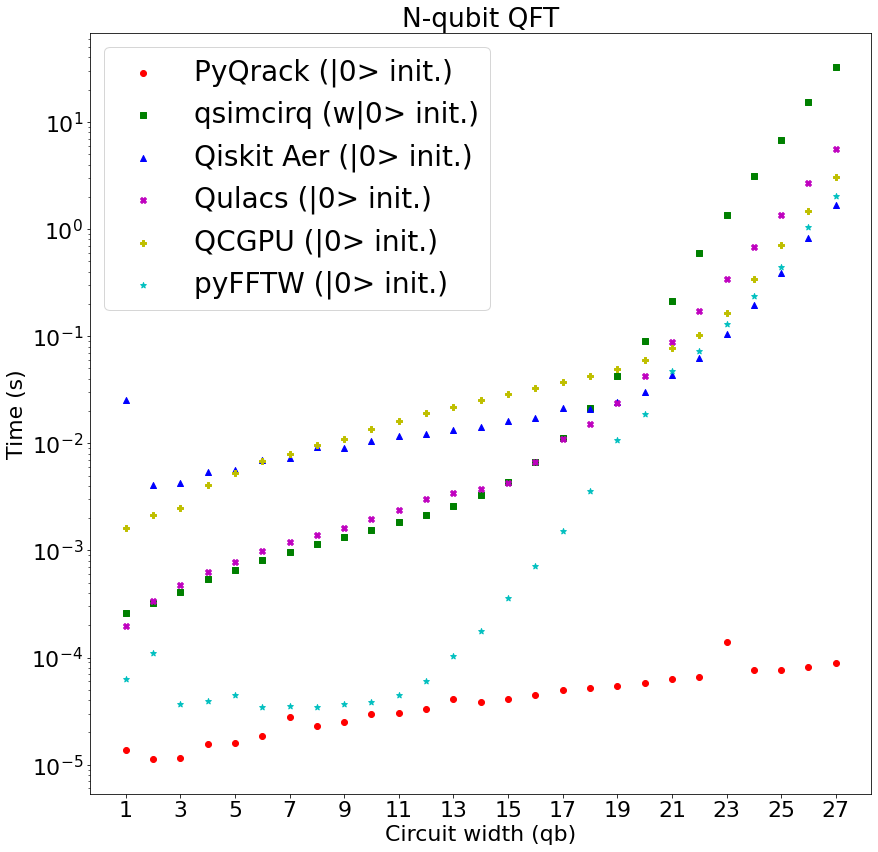

In [16]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cuquantum_results.keys()
y = cuquantum_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "qsimcirq (w|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

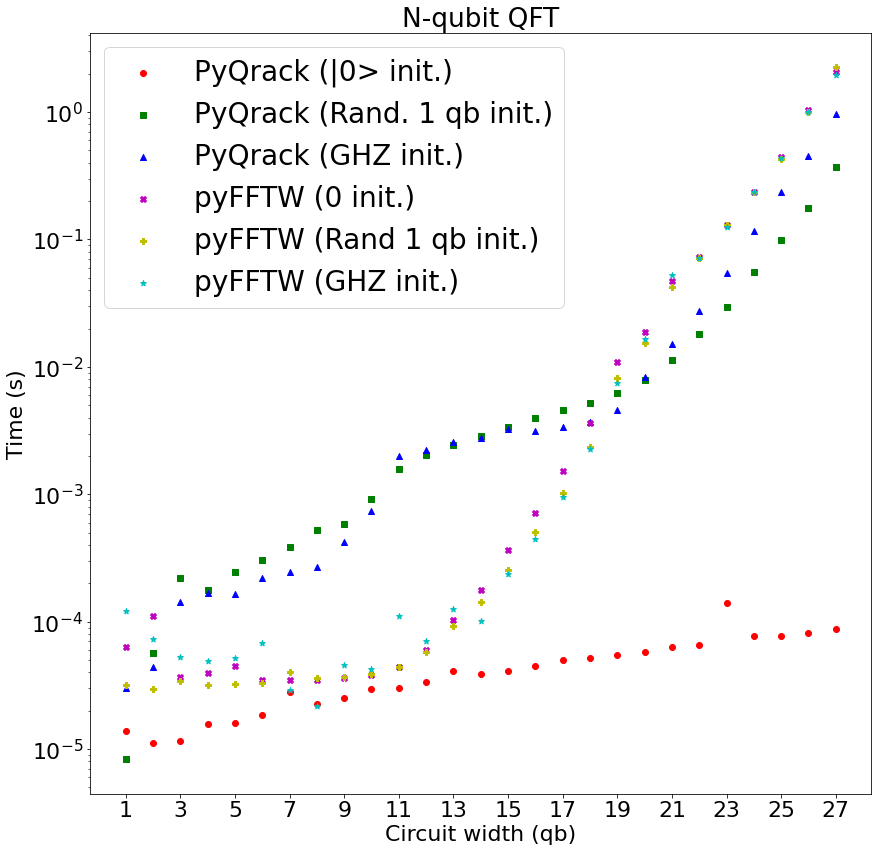

In [17]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("cymbgr")
markers = list("*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_k_results.keys()
y = fftw_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "PyQrack (GHZ init.)", "pyFFTW (0 init.)", "pyFFTW (Rand 1 qb init.)", "pyFFTW (GHZ init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_ghz_chart.png', dpi=100)

In [18]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2
Linux-5.19.0-35-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-35-generic', version='#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2', machine='x86_64')
Linux
x86_64


In [19]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [20]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'